In [39]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision import datasets
from torchvision.transforms import ToTensor

## Source

Followed [PyTorch tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) and [this medium article](https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118) for initial setup of CNN network trained and tested using MNIST.

## Settings

In [3]:
USE_SOFTMAX = False

## Download the MNIST Dataset

In [4]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

## Plot Examples

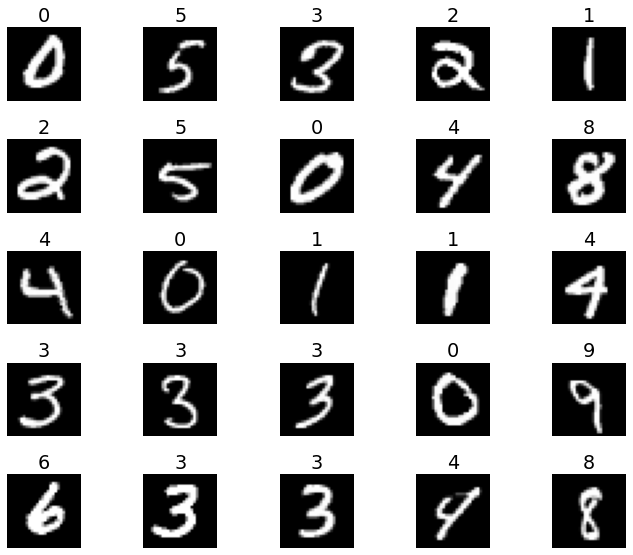

In [5]:
cols, rows = 5, 5
fig, ax = plt.subplots(cols, rows, figsize=(10, 8))

for i in range(cols * rows):
    col, row = i // 5, i % 5
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    ax[col, row].set_title(label)
    ax[col, row].axis("off")
    ax[col, row].imshow(img.squeeze(), cmap="gray")
fig.tight_layout()

## DataLoaders

In [6]:
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=100, 
    shuffle=True, 
    num_workers=1
)
    
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=100, 
    shuffle=True, 
    num_workers=1
)

train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x125879e80>,
 <torch.utils.data.dataloader.DataLoader at 0x125879ee0>)

## Network Definition

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=16,
            kernel_size=5,
            stride=1,
            padding=0,
        )
        self.pool = nn.MaxPool2d(
            kernel_size=2
        )
        self.conv2 = nn.Conv2d(
            in_channels=1,
            out_channels=16,
            kernel_size=5,
            # stride=1,
            # padding=2,
        )
        self.fc = nn.Linear(
            in_features=16*12*12,
            out_features=10
        )


    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        if USE_SOFTMAX:
            x = F.softmax(x, dim=1)

        return x    # return x for visualization

In [8]:
cnn = CNN()
cnn

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc): Linear(in_features=2304, out_features=10, bias=True)
)

In [9]:
criterion = nn.CrossEntropyLoss()   
criterion

CrossEntropyLoss()

In [10]:
optimizer = optim.SGD(cnn.parameters(), lr=0.01)   
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0
    nesterov: False
    weight_decay: 0
)

## Training

In [11]:
num_epochs = 20
total_step = len(train_loader)

cnn.train()

final_bx_arrs = []
final_by_arrs = []
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        b_x = Variable(inputs, requires_grad=True)
        b_y = Variable(labels)
    
        output = cnn(b_x)
        loss = criterion(output, b_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')

        if epoch == num_epochs-1:
            final_bx_arrs.append(b_x)
            final_by_arrs.append(b_y)

Epoch [1/20], Step [100/600], Loss: 1.2652
Epoch [1/20], Step [200/600], Loss: 0.6017
Epoch [1/20], Step [300/600], Loss: 0.5900
Epoch [1/20], Step [400/600], Loss: 0.3880
Epoch [1/20], Step [500/600], Loss: 0.4100
Epoch [1/20], Step [600/600], Loss: 0.5570
Epoch [2/20], Step [100/600], Loss: 0.2902
Epoch [2/20], Step [200/600], Loss: 0.4080
Epoch [2/20], Step [300/600], Loss: 0.3717
Epoch [2/20], Step [400/600], Loss: 0.3249
Epoch [2/20], Step [500/600], Loss: 0.5065
Epoch [2/20], Step [600/600], Loss: 0.2692
Epoch [3/20], Step [100/600], Loss: 0.2622
Epoch [3/20], Step [200/600], Loss: 0.4929
Epoch [3/20], Step [300/600], Loss: 0.2652
Epoch [3/20], Step [400/600], Loss: 0.1926
Epoch [3/20], Step [500/600], Loss: 0.1558
Epoch [3/20], Step [600/600], Loss: 0.3766
Epoch [4/20], Step [100/600], Loss: 0.3375
Epoch [4/20], Step [200/600], Loss: 0.3035
Epoch [4/20], Step [300/600], Loss: 0.3271
Epoch [4/20], Step [400/600], Loss: 0.1457
Epoch [4/20], Step [500/600], Loss: 0.3376
Epoch [4/20

## Testing

In [12]:
cnn.eval()

accuracy = 0
for inputs, labels in test_loader:
    test_output = cnn(inputs)
    pred_y = torch.max(test_output, 1).indices
    accuracy += (1/len(test_loader))*(pred_y == labels).sum().item() / float(labels.size(0))

print(f'Test Accuracy: {accuracy:.5f}')

Test Accuracy: 0.97300


## Adversarial Examples

In [13]:
cnn.eval()

epsilon = 0.05

orig_output = cnn(b_x.data)
orig_output_softmax = torch.nn.functional.softmax(orig_output, dim=1)
orig_preds = orig_output_softmax.max(axis=1).indices
orig_conf = orig_output_softmax.max(axis=1).values

grad_preds = torch.max(cnn(np.sign(b_x.grad.sign())), 1).indices

adv_output = cnn(b_x.data + epsilon*np.sign(b_x.grad))
adv_output_softmax = torch.nn.functional.softmax(adv_output, dim=1)
adv_preds = adv_output_softmax.max(axis=1).indices
adv_conf = adv_output_softmax.max(axis=1).values

In [26]:
(b_x.grad.sign())[img_idx, :, :, :].squeeze().shape

torch.Size([28, 28])

In [28]:
(b_x.grad.sign())[img_idx, :, :, :].squeeze()

tensor([[-1., -1., -1., -1., -1.,  1.,  1.,  1.,  1., -1.,  1., -1.,  1.,  1.,
          1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  0.],
        [ 1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1., -1., -1.,  1.,  1.,
          1.,  1., -1., -1., -1., -1., -1., -1., -1.,  1., -1.,  1., -1.,  0.],
        [ 1., -1.,  1.,  1., -1., -1., -1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,
          1.,  1., -1., -1., -1.,  1., -1., -1., -1., -1., -1., -1., -1.,  0.],
        [-1., -1.,  1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  0.],
        [-1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  0.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  0.],
        [-1., -1., -1., -1., -1., -1., -1., -1

In [45]:
plt.rc('font', size=36)

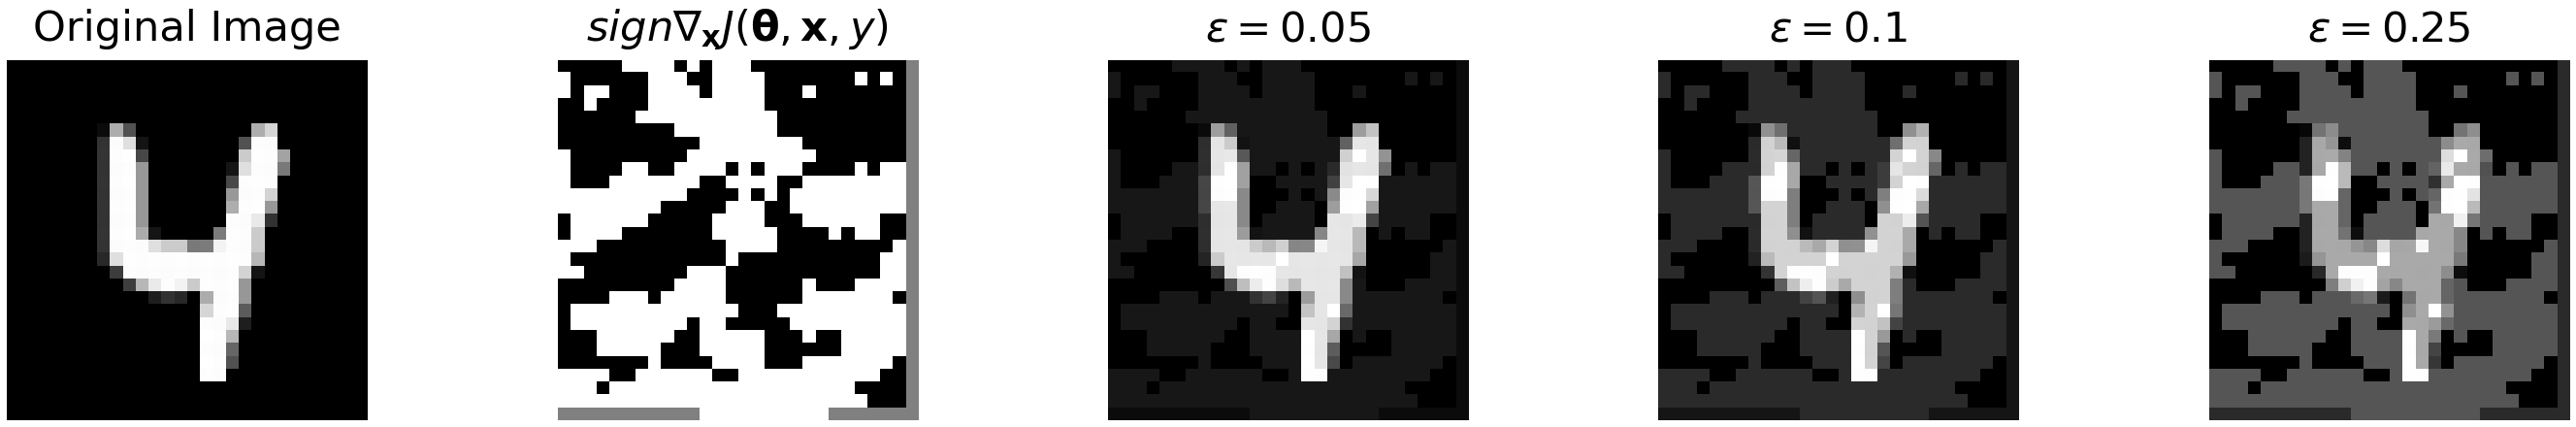

In [46]:
img_idx = 4
fig, ax = plt.subplots(1, 5, figsize=(40, 7))

orig_img = b_x.data[img_idx, :, :, :].squeeze()
grad_img = (b_x.grad.sign())[img_idx, :, :, :].squeeze()

ax[0].imshow(orig_img, cmap="gray")
ax[0].set_title(f'Original Image', pad=20)
ax[0].axis('off')

ax[1].imshow(grad_img, cmap="gray")
ax[1].set_title(r'$sign{\nabla_{\mathbf{x}}J(\mathbf{\theta}, \mathbf{x}, y)}$', pad=20)
ax[1].axis('off')

ax[2].imshow(orig_img+0.05*grad_img, cmap="gray")
ax[2].set_title('$\epsilon=0.05$', pad=20)
ax[2].axis('off')

ax[3].imshow(orig_img+0.1*grad_img, cmap="gray")
ax[3].set_title('$\epsilon=0.1$', pad=20)
ax[3].axis('off')

ax[4].imshow(orig_img+0.25*grad_img, cmap="gray")
ax[4].set_title('$\epsilon=0.25$', pad=20)
ax[4].axis('off')
fig.tight_layout()

plt.savefig(os.path.join(f"mnist_adversarial_examples.png"), pad_inches=0.2, bbox_inches='tight')

IndexError: tensors used as indices must be long, byte or bool tensors

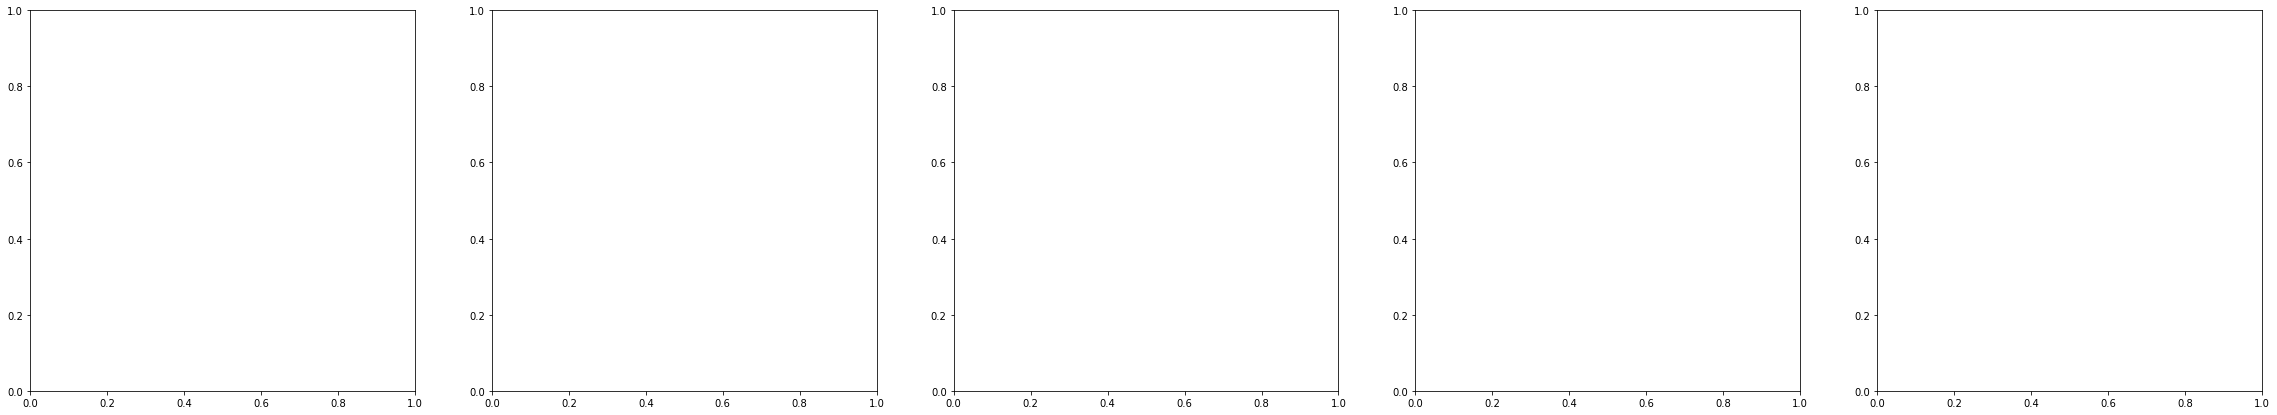

In [ ]:
img_idx = 1
fig, ax = plt.subplots(1, 5, figsize=(40, 7))

orig_img = b_x.data[img_idx, :, :, :].squeeze()
grad_img = (b_x.grad.sign())[orig_img, :, :, :].squeeze()

ax[0].imshow(orig_img, cmap="gray")
# ax[i,0].set_title(f'{orig_preds[j].item()} - {orig_conf[j].item():.3f}')
ax[0].axis('off')

ax[1].imshow(grad_img, cmap="gray")
# ax[i,1].set_title(grad_preds[j].item())
ax[1].axis('off')

ax[2].imshow(epsilon*grad_img, cmap="gray")
# ax[i,2].set_title(f'{adv_preds[j].item()} - {adv_conf[j].item():.3f}')
ax[2].axis('off')

ax[3].imshow(epsilon*grad_img, cmap="gray")
# ax[i,2].set_title(f'{adv_preds[j].item()} - {adv_conf[j].item():.3f}')
ax[3].axis('off')

ax[4].imshow(epsilon*grad_img, cmap="gray")
# ax[i,2].set_title(f'{adv_preds[j].item()} - {adv_conf[j].item():.3f}')
ax[4].axis('off')
fig.tight_layout()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

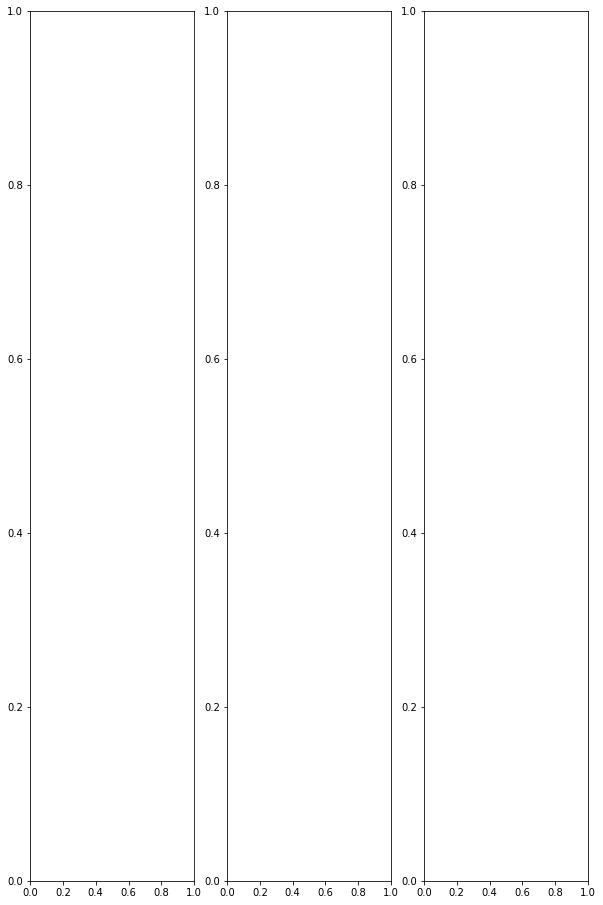

In [ ]:
example_start_ind = 0
n_examples = 10
fig, ax = plt.subplots(n_examples, 3, figsize=(10, 16))
for i, j in enumerate(range(example_start_ind, example_start_ind+n_examples)):
    orig_img = b_x.data[j, :, :, :].squeeze()
    grad_img = (b_x.grad.sign())[j, :, :, :].squeeze()
    adv_img = orig_img + epsilon*grad_img

    ax[i,0].imshow(orig_img, cmap="gray")
    # ax[i,0].set_title(f'{orig_preds[j].item()} - {orig_conf[j].item():.3f}')
    ax[i,0].axis('off')

    ax[i,1].imshow(grad_img, cmap="gray")
    # ax[i,1].set_title(grad_preds[j].item())
    ax[i,1].axis('off')

    ax[i,2].imshow(adv_img, cmap="gray")
    # ax[i,2].set_title(f'{adv_preds[j].item()} - {adv_conf[j].item():.3f}')
    ax[i,2].axis('off')
fig.tight_layout()

In [102]:
epsilon = 0.1

updated_bx = final_bx_arrs[0] + epsilon*np.sign(final_bx_arrs[0].grad)
grad_bx = updated_bx.detach().numpy()
original_bx = final_bx_arrs[0].detach().numpy()

total_by = final_by_arrs[0].detach().numpy()

for i in range(1,len(final_bx_arrs)):
    updated_bx = final_bx_arrs[i] + epsilon*np.sign(final_bx_arrs[i].grad)
    grad_bx = np.vstack((grad_bx, updated_bx.detach().numpy()))
    original_bx = np.vstack((original_bx, final_bx_arrs[i].detach().numpy()))
    total_by = np.hstack((total_by, final_by_arrs[i].detach().numpy()))

In [103]:
original_bx.shape, grad_bx.shape, total_by.shape

((60000, 1, 28, 28), (60000, 1, 28, 28), (60000,))

In [104]:
test_output = cnn(torch.tensor(original_bx))
pred_y = torch.max(test_output, 1).indices
accuracy = (pred_y == torch.tensor(total_by)).sum().item() / float(total_by.size)
accuracy


0.9757666666666667

In [105]:
test_output = cnn(torch.tensor(grad_bx))
pred_y = torch.max(test_output, 1).indices
accuracy = (pred_y == torch.tensor(total_by)).sum().item() / float(total_by.size)
accuracy


0.38158333333333333

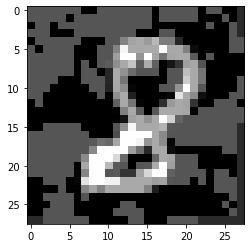

In [87]:
plt.imshow(grad_bx[0,0,:,:], cmap="gray")

In [94]:
# np.savez('x_orig.npyz', original_bx)
# np.save(f'x_grad_{epsilon}.npy', grad_bx)
# np.save('y_grad.npy', total_by)

In [95]:
# test = np.load('x_orig.npyz.npz')

In [14]:
# cnn.eval()

# for i, (inputs, labels) in enumerate(train_loader):
#     b_x = Variable(inputs, requires_grad=True)
#     output = cnn(b_x)
#     loss = criterion(output, b_y)
#     optimizer.zero_grad()
#     loss.backward()

In [15]:
# test_output = cnn(b_x.grad.sign())
# pred_y = torch.max(test_output, 1).indices
# pred_y